In [1]:
import os
import csv
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
DATA_DIR = "URECA_DATA1"  # Folder containing subfolders for each plant
OUTPUT_CSV = "plant_health_timeseries.csv"
IMAGE_SIZE = (800, 800)
GREEN_THRESHOLD = 0.6

In [3]:
def analyze_rgb_dominance(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(IMAGE_SIZE)
    img_array = np.asarray(img) / 255.0

    R = img_array[:, :, 0]
    G = img_array[:, :, 1]
    B = img_array[:, :, 2]

    green_mask = (G > GREEN_THRESHOLD) & (G > R) & (G > B)
    red_mask = (R > 0.6) & (R > G) & (R > B)
    blue_mask = (B > 0.6) & (B > R) & (B > G)

    total_pixels = green_mask.size
    green_pct = np.sum(green_mask) / total_pixels * 100
    red_pct = np.sum(red_mask) / total_pixels * 100
    blue_pct = np.sum(blue_mask) / total_pixels * 100
    neutral_pct = 100 - (green_pct + red_pct + blue_pct)

    return green_pct, red_pct, blue_pct, neutral_pct

In [4]:
records = []

for plant in sorted(os.listdir(DATA_DIR)):
    plant_path = os.path.join(DATA_DIR, plant)
    if os.path.isdir(plant_path):
        for image_name in sorted(os.listdir(plant_path)):
            if image_name.lower().endswith(('jpg', 'png', 'jpeg')):
                image_path = os.path.join(plant_path, image_name)
                green, red, blue, neutral = analyze_rgb_dominance(image_path)
                day = os.path.splitext(image_name)[0]  # e.g., 'day1'
                records.append([plant, day, green, red, blue, neutral])

In [5]:
with open(OUTPUT_CSV, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Plant", "Day", "Green%", "Red%", "Blue%", "Neutral%"])
    writer.writerows(records)

<Figure size 1000x600 with 0 Axes>

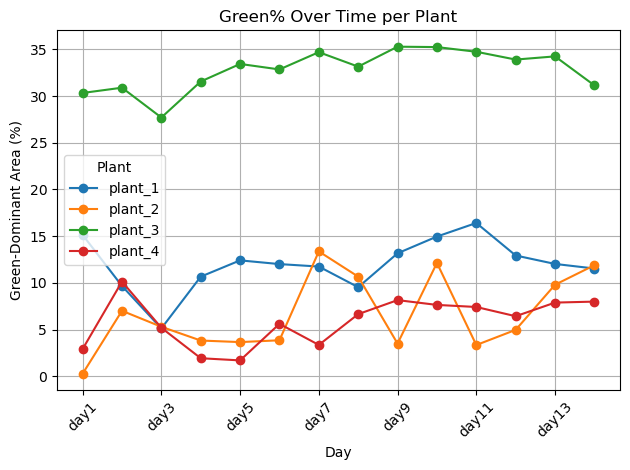

In [6]:
# Load your data
df = pd.read_csv(OUTPUT_CSV)

# Extract numeric part of the 'Day' to sort correctly
df['Day_num'] = df['Day'].str.extract('(\d+)').astype(int)
df_sorted = df.sort_values(by='Day_num')

# Create pivot table and reorder based on numeric day
pivot = pd.pivot_table(df_sorted, index='Day', columns='Plant', values='Green%')
ordered_days = df_sorted.drop_duplicates('Day').sort_values('Day_num')['Day']
pivot = pivot.reindex(ordered_days)

# Plot
plt.figure(figsize=(10, 6))
sns_plot = pivot.plot(marker='o')
plt.title("Green% Over Time per Plant")
plt.ylabel("Green-Dominant Area (%)")
plt.xlabel("Day")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
summary = df.groupby("Plant")[["Green%", "Red%", "Blue%", "Neutral%"]].agg(['mean', 'std'])
print("\nSummary Statistics:")
print(summary.round(2))


Summary Statistics:
        Green%         Red%       Blue%       Neutral%      
          mean   std   mean   std  mean   std     mean   std
Plant                                                       
plant_1  11.95  2.79  12.04  3.35  3.32  3.15    72.69  1.96
plant_2   6.68  4.11   2.60  2.72  7.22  3.52    83.50  5.52
plant_3  32.80  2.21   0.39  0.38  0.03  0.06    66.78  1.95
plant_4   5.93  2.59  14.09  3.58  1.86  1.83    78.12  4.52


<Figure size 1000x600 with 0 Axes>

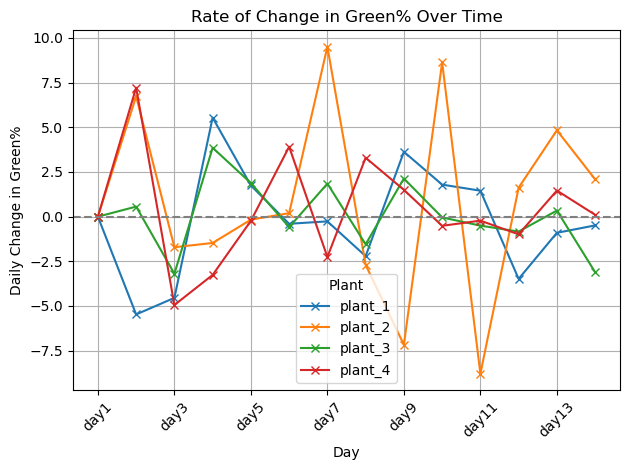

In [8]:
df['Day_num'] = df['Day'].str.extract('(\d+)').astype(int)
df_sorted = df.sort_values(by=['Plant', 'Day_num'])
df_sorted['Green% Rate'] = df_sorted.groupby('Plant')['Green%'].diff().fillna(0)

pivot = pd.pivot_table(df_sorted, index='Day', columns='Plant', values='Green% Rate')

ordered_days = df_sorted.drop_duplicates('Day').sort_values('Day_num')['Day']
pivot = pivot.reindex(ordered_days)

plt.figure(figsize=(10, 6))
sns_rate_plot = pivot.plot(marker='x')
plt.title("Rate of Change in Green% Over Time")
plt.ylabel("Daily Change in Green%")
plt.xlabel("Day")
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


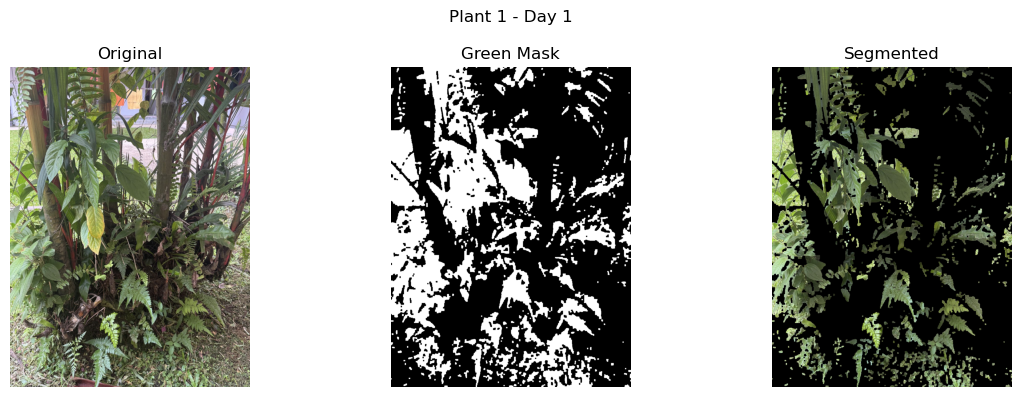

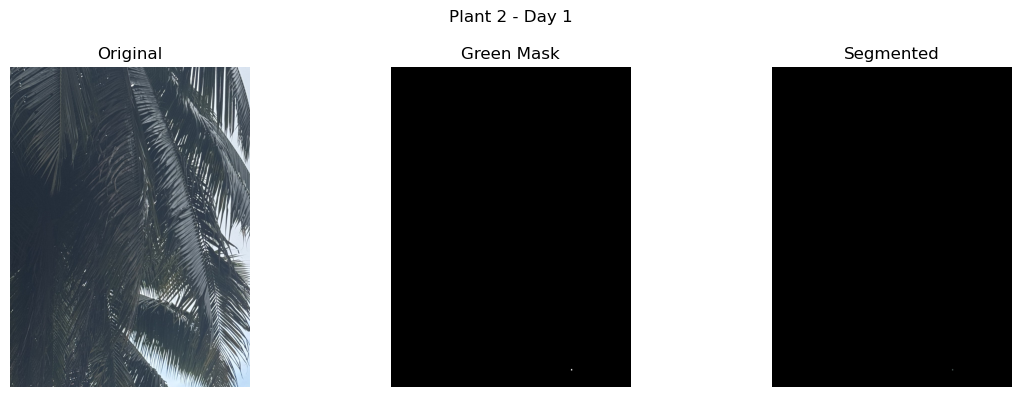

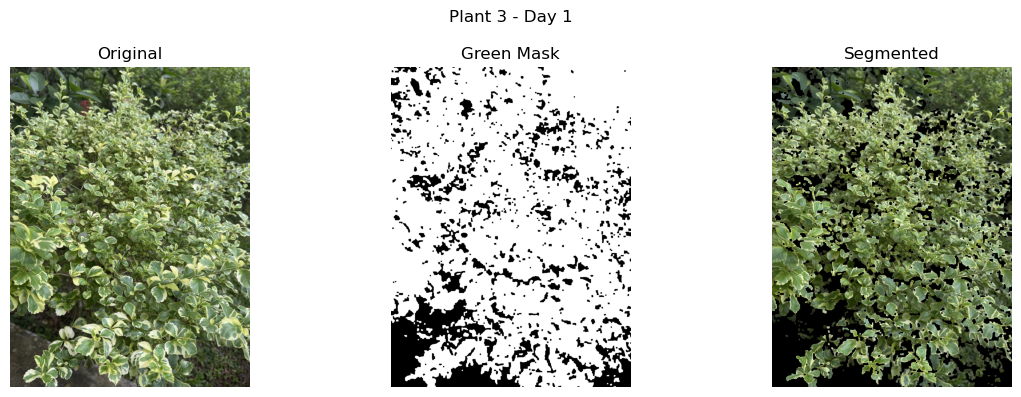

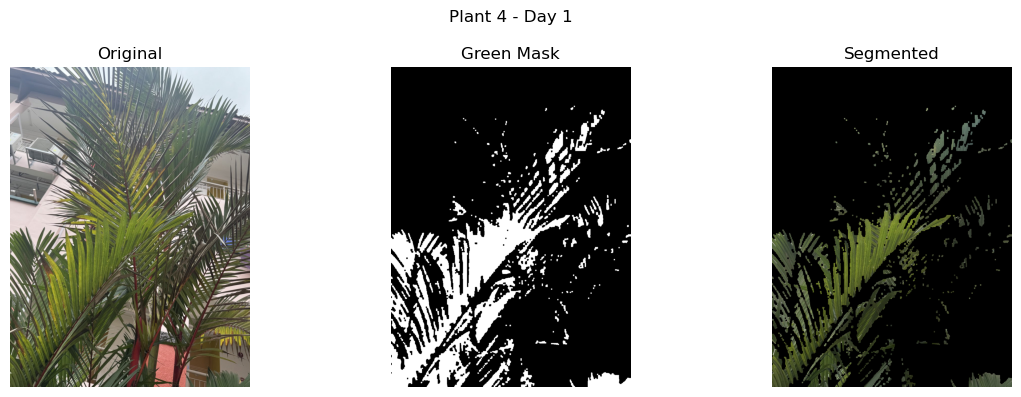

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Base folder path
base_path = "C:\\Users\\Windows 10\\Downloads\\URECA_DATA1"

# Green HSV range
lower_green = np.array([35, 40, 40])
upper_green = np.array([85, 255, 255])

# Morph kernel
kernel = np.ones((5, 5), np.uint8)

# Loop over each plant and each day
for plant_num in range(1, 5):
    for day in range(1, 15):
        # Construct file path
        img_path = os.path.join(base_path, f"plant_{plant_num}", f"day{day}.jpg")
        
        if not os.path.exists(img_path):
            print(f"Missing: {img_path}")
            continue

        # Load image with PIL and convert to RGB
        img_pil = Image.open(img_path).convert("RGB")
        img_rgb = np.array(img_pil)
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

        # Create green mask
        mask = cv2.inRange(hsv, lower_green, upper_green)
        mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

        # Segment green regions
        segmented = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_cleaned)

        # OPTIONAL: Display first image from each plant
        if day == 1:
            plt.figure(figsize=(12, 4))
            plt.suptitle(f"Plant {plant_num} - Day {day}")
            plt.subplot(1, 3, 1)
            plt.imshow(img_rgb)
            plt.title("Original")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(mask_cleaned, cmap="gray")
            plt.title("Green Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(segmented)
            plt.title("Segmented")
            plt.axis("off")
            plt.tight_layout()
            plt.show()

        # OPTIONAL: Save segmented image
        # out_dir = os.path.join(base_path, f"plant_{plant_num}", "segmented")
        # os.makedirs(out_dir, exist_ok=True)
        # out_path = os.path.join(out_dir, f"day{day}_segmented.png")
        # Image.fromarray(segmented).save(out_path)


In [11]:
#saves the segmented images to the folder
DATA_DIR = "URECA_DATA1"
OUTPUT_CSV = "plant_health_segmented_data.csv"
IMAGE_SIZE = (800, 800)
GREEN_THRESHOLD = 0.6

# Green HSV range for segmentation
lower_green = np.array([35, 40, 40])
upper_green = np.array([85, 255, 255])
kernel = np.ones((5, 5), np.uint8)

# Function to analyze RGB dominance
def analyze_rgb_dominance(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(IMAGE_SIZE)
    img_array = np.asarray(img) / 255.0

    R = img_array[:, :, 0]
    G = img_array[:, :, 1]
    B = img_array[:, :, 2]

    green_mask = (G > GREEN_THRESHOLD) & (G > R) & (G > B)
    red_mask = (R > 0.6) & (R > G) & (R > B)
    blue_mask = (B > 0.6) & (B > R) & (B > G)

    total_pixels = green_mask.size
    green_pct = np.sum(green_mask) / total_pixels * 100
    red_pct = np.sum(red_mask) / total_pixels * 100
    blue_pct = np.sum(blue_mask) / total_pixels * 100
    neutral_pct = 100 - (green_pct + red_pct + blue_pct)

    return green_pct, red_pct, blue_pct, neutral_pct

# List to store data
records = []

# Loop over each plant and each day
for plant_num in range(1, 5):
    for day in range(1, 15):
        # Construct file path
        img_path = os.path.join(DATA_DIR, f"plant_{plant_num}", f"day{day}.jpg")
        
        # Check if file exists, and try with both .jpg and .jpeg extensions
        if not os.path.exists(img_path):
            img_path = os.path.join(DATA_DIR, f"plant_{plant_num}", f"day{day}.jpeg")
        
        if not os.path.exists(img_path):
            print(f"Missing: {img_path}")
            continue

        # Load image and convert to BGR
        img_pil = Image.open(img_path).convert("RGB")
        img_rgb = np.array(img_pil)
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

        # Create green mask and clean
        mask = cv2.inRange(hsv, lower_green, upper_green)
        mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)

        # Segment the green region
        segmented = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_cleaned)

        # Save segmented image
        out_dir = os.path.join(DATA_DIR, f"plant_{plant_num}", "segmented")
        os.makedirs(out_dir, exist_ok=True)
        out_path = os.path.join(out_dir, f"day{day}_segmented.png")
        Image.fromarray(segmented).save(out_path)

        # Analyze and store green, red, blue, and neutral percentages
        green, red, blue, neutral = analyze_rgb_dominance(out_path)
        records.append([plant_num, f"day{day}", green, red, blue, neutral])


In [15]:
DATA_DIR = "URECA_DATA_SEGMENTED"  # Folder containing subfolders for each plant
OUTPUT_CSV = "plant_health_segmented_data.csv"
IMAGE_SIZE = (800, 800)
GREEN_THRESHOLD = 0.6


In [16]:
def analyze_rgb_dominance(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(IMAGE_SIZE)
    img_array = np.asarray(img) / 255.0

    R = img_array[:, :, 0]
    G = img_array[:, :, 1]
    B = img_array[:, :, 2]

    green_mask = (G > GREEN_THRESHOLD) & (G > R) & (G > B)
    red_mask = (R > 0.6) & (R > G) & (R > B)
    blue_mask = (B > 0.6) & (B > R) & (B > G)

    total_pixels = green_mask.size
    green_pct = np.sum(green_mask) / total_pixels * 100
    red_pct = np.sum(red_mask) / total_pixels * 100
    blue_pct = np.sum(blue_mask) / total_pixels * 100
    neutral_pct = 100 - (green_pct + red_pct + blue_pct)

    return green_pct, red_pct, blue_pct, neutral_pct

In [17]:
records = []

for plant in sorted(os.listdir(DATA_DIR)):
    plant_path = os.path.join(DATA_DIR, plant)
    if os.path.isdir(plant_path):
        for image_name in sorted(os.listdir(plant_path)):
            if image_name.lower().endswith(('jpg', 'png', 'jpeg')):
                image_path = os.path.join(plant_path, image_name)
                green, red, blue, neutral = analyze_rgb_dominance(image_path)
                day = os.path.splitext(image_name)[0]  # e.g., 'day1'
                records.append([plant, day, green, red, blue, neutral])


In [22]:
with open(OUTPUT_CSV, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Plant", "Day", "Green%", "Red%", "Blue%", "Neutral%"])
    writer.writerows(records)


<Figure size 1000x600 with 0 Axes>

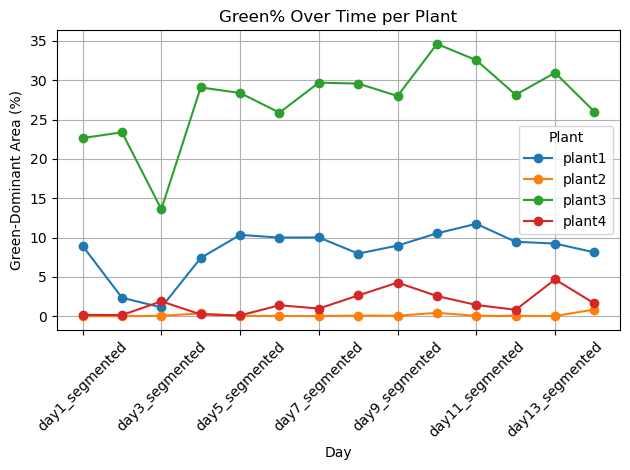

In [23]:
# Load your data
df = pd.read_csv(OUTPUT_CSV)

# Extract numeric part of the 'Day' to sort correctly
df['Day_num'] = df['Day'].str.extract('(\d+)').astype(int)
df_sorted = df.sort_values(by='Day_num')

# Create pivot table and reorder based on numeric day
pivot = pd.pivot_table(df_sorted, index='Day', columns='Plant', values='Green%')
ordered_days = df_sorted.drop_duplicates('Day').sort_values('Day_num')['Day']
pivot = pivot.reindex(ordered_days)

# Plot
plt.figure(figsize=(10, 6))
sns_plot = pivot.plot(marker='o')
plt.title("Green% Over Time per Plant")
plt.ylabel("Green-Dominant Area (%)")
plt.xlabel("Day")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
summary = df.groupby("Plant")[["Green%", "Red%", "Blue%", "Neutral%"]].agg(['mean', 'std'])
print("\nSummary Statistics:")
print(summary.round(2))


Summary Statistics:
       Green%       Red%       Blue%       Neutral%      
         mean   std mean   std  mean   std     mean   std
Plant                                                    
plant1   8.29  3.01  0.0  0.00  0.01  0.01    91.70  3.01
plant2   0.14  0.24  0.0  0.00  0.00  0.00    99.86  0.24
plant3  27.31  5.11  0.0  0.01  0.00  0.00    72.68  5.11
plant4   1.63  1.47  0.0  0.00  0.00  0.00    98.37  1.47


<Figure size 1000x600 with 0 Axes>

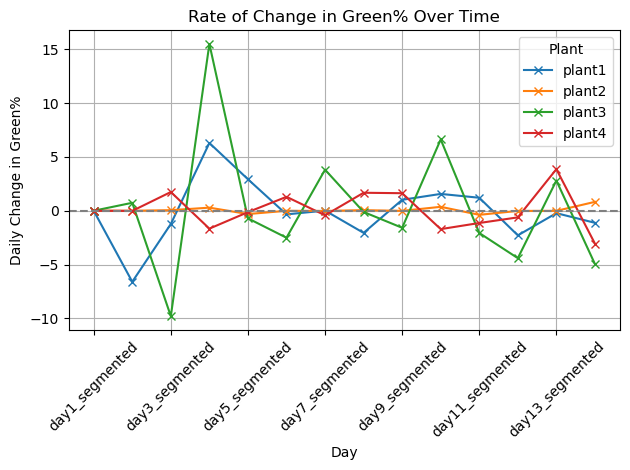

In [25]:
df['Day_num'] = df['Day'].str.extract('(\d+)').astype(int)
df_sorted = df.sort_values(by=['Plant', 'Day_num'])
df_sorted['Green% Rate'] = df_sorted.groupby('Plant')['Green%'].diff().fillna(0)

pivot = pd.pivot_table(df_sorted, index='Day', columns='Plant', values='Green% Rate')

ordered_days = df_sorted.drop_duplicates('Day').sort_values('Day_num')['Day']
pivot = pivot.reindex(ordered_days)

plt.figure(figsize=(10, 6))
sns_rate_plot = pivot.plot(marker='x')
plt.title("Rate of Change in Green% Over Time")
plt.ylabel("Daily Change in Green%")
plt.xlabel("Day")
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
